In [1]:
def public_attrs(o, contains=''):
    contains = contains if isinstance(contains, list) else [contains]
    return [a for a in dir(o) if not a.startswith('_') and any(c in a for c in contains)]

This notebooks tests new code in diffusers: `ControlledUNet2DConditionModel.forward`

In [2]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union

import numpy as np

import torch
import torch.nn as nn
import torch.utils.checkpoint
from torch import tensor

In [3]:
device = 'cpu'
device_dtype = torch.float32

In [4]:
from diffusers.configuration_utils import ConfigMixin
from diffusers.loaders import UNet2DConditionLoadersMixin
from diffusers.utils import BaseOutput, logging

from diffusers.models.embeddings import (
    GaussianFourierProjection,
    TimestepEmbedding,
    Timesteps,
    get_timestep_embedding
)
from diffusers.models.modeling_utils import ModelMixin
from diffusers.models.unet_2d_blocks import (
    CrossAttnDownBlock2D,
    DownBlock2D,
    CrossAttnUpBlock2D,
    UpBlock2D,
)
from diffusers.models.unet_2d_condition import UNet2DConditionModel

In [5]:
from diffusers.models.unet_2d_condition_control import ControlledUNet2DConditionModel

In [6]:
def zero_module(module):
    for p in module.parameters():
        nn.init.zeros_(p)
    return module

In [7]:
params = {
    'in_channels': 4,
    'out_channels': 4,
    'hint_channels': 3,
    'model_channels': 320,
    'attention_resolutions': [4, 2],
    'num_res_blocks': 2,
}

In [8]:
two_stream_model = ControlledUNet2DConditionModel(**params)

___

Let's run the forward method manually.

In [9]:
prompt = 'A turtle'

In [10]:
from diffusers.utils import load_image

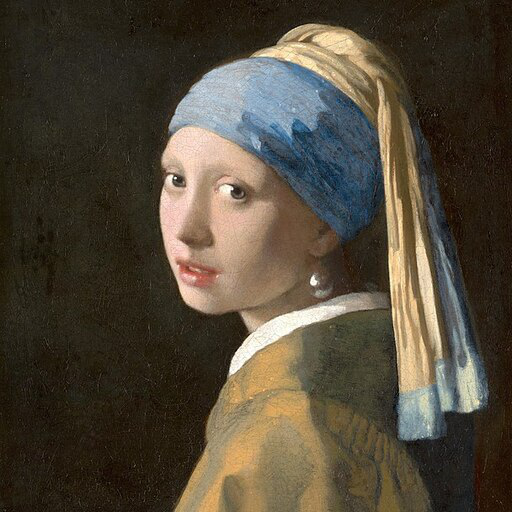

In [11]:
try:
    original_image = load_image(
        'https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png'
    )
except Exception:
    original_image = load_image('/Users/umer/Desktop/input_image_vermeer.png')
image = original_image
image

I will need to use some preprocessing functions from `StableDiffusionControlNetPipeline`, so let create an instance

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

In [13]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=device_dtype)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=device_dtype
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


There is (edit: was) an issue below: `ValueError: not enough values to unpack (expected 3, got 2)` when running `hidden_states = attn(...)`

The issue is that deep inside diffusers, these line

    1006 batch_size, sequence_length, _ = (
    1007     hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
    1008 )

expect `encoder_hidden_states` to be 3D, but I'm passing `encoder_hidden_states = emb` which is 2D.
This is a mistake as `emb` represents the time information, but `encoder_hidden_states` should contain the conditioning information (eg the text prompt).

Let's look into the text-conditioning information. From the fast.ai course, I know that the text information is
1. first tokenized
2. then embedded ("encoded") via CLIP
3. then passed into the `unet` in every denoising step (`pred = unet(input, t, encoder_hidden_states=text_embeddings).sample`)

**Let's tokenize & embed the prompt**

In [14]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

type(tokenizer), type(text_encoder)

(transformers.models.clip.tokenization_clip.CLIPTokenizer,
 transformers.models.clip.modeling_clip.CLIPTextModel)

In [15]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
text_embeddings.shape

torch.Size([1, 77, 768])

I first need to understand what exactly is passed into the the unet & how to construct it for testing purposes.

**Q:** What is passed to `ControlledUNet2DConditionModel.forward`?

**A:** Here's the part of `StableDiffusionControlNetPipeline.__call__` where the unet is used:

    noise_pred = self.unet(
        latent_model_input,
        t,
        encoder_hidden_states=prompt_embeds,
        cross_attention_kwargs=cross_attention_kwargs,
        down_block_additional_residuals=down_block_res_samples,
        mid_block_additional_residual=mid_block_res_sample,
        return_dict=False,
    )[0]

So we need:
1. Required:
- `latent_model_input`
- `t`
- `encoder_hidden_states` = `prompt_embeds`
2. Defaulting
- `cross_attention_kwargs` -> defaults to `None`
- `return_dict` -> defaults to `False`
3. Not required. These are to pass information from the controlnet to the unet. But in our two_stream_model already has both in it; he info passing beteen control and base is done within it.  
- `down_block_additional_residuals`
- `mid_block_additional_residual`

**Q:** How is `prompt_embeds` constructed?

In [16]:
guidance_scale = 7.5
do_classifier_free_guidance = guidance_scale > 1.0

In [17]:
# 2. Define call parameters
batch_size = 1 # because prompt is a single string

Next, I need to encode the prompt via:

    prompt_embeds, negative_prompt_embeds = self.encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        lora_scale=text_encoder_lora_scale,
    )

Let's use the `encode_prompt` of the `StableDiffusionControlNetPipeline` I instantiated above

In [18]:
# default values
negative_prompt  = None
num_images_per_prompt  = 1
prompt_embeds: Optional[torch.FloatTensor] = None
negative_prompt_embeds: Optional[torch.FloatTensor] = None
text_encoder_lora_scale = None

In [19]:
prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
    negative_prompt,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    lora_scale=text_encoder_lora_scale,
)

In [20]:
prompt_embeds.shape, negative_prompt_embeds.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [21]:
prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds]) # do_classifier_free_guidance == True

In [22]:
prompt_embeds.shape

torch.Size([2, 77, 768])

In [23]:
# 6. Prepare latent variables
num_channels_latents = two_stream_model.base_model.config.in_channels # we're using our unet here!
num_channels_latents

4

In [24]:
# Default values
height, width = None, None
generator = None
latents = None
guess_mode = False

In [25]:
# 4. Prepare image
image = pipe.prepare_image(
    image=image,
    width=width,
    height=height,
    batch_size=batch_size * num_images_per_prompt,
    num_images_per_prompt=num_images_per_prompt,
    device=device,
    dtype=controlnet.dtype,
    do_classifier_free_guidance=do_classifier_free_guidance,
    guess_mode=guess_mode,
)
height, width = image.shape[-2:]

In [26]:
height, width, image.shape

(512, 512, torch.Size([2, 3, 512, 512]))

In [27]:
# Default values
num_inference_steps = 50

In [28]:
# 5. Prepare timesteps
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

In [29]:
timesteps

tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1])

In [30]:
# 6. Prepare latent variables
latents = pipe.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents,
)

In [31]:
latents.shape

torch.Size([1, 4, 64, 64])

In [32]:
# 8. Denoising loop
num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order

i,t = 0, timesteps[0] # NOTE: We only do 1 step for testing

In [33]:
# expand the latents if we are doing classifier free guidance
latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

In [34]:
# controlnet(s) inference
# guess_mode == False
control_model_input = latent_model_input
controlnet_prompt_embeds = prompt_embeds

Now we should have everything we need

In [35]:
latent_model_input.shape, t, prompt_embeds.shape

(torch.Size([2, 4, 64, 64]), tensor(981), torch.Size([2, 77, 768]))

In [36]:
x = latent_model_input
t = t
c = {}
no_control =False

**Q:** `hint` is missing. How do I compute it?

**A:** In `cu.get_sdxl_sample`, the `hint` is set to the incoming `guidance` param. Below is how `guidance` is created

In [37]:
hint_image = original_image

In [38]:
import cv2
class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

In [39]:
def get_canny_edges(image, size=512, threshold=(50, 200)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

In [40]:
import matplotlib.pyplot as plt

In [41]:
edges = get_canny_edges(hint_image)
edges

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

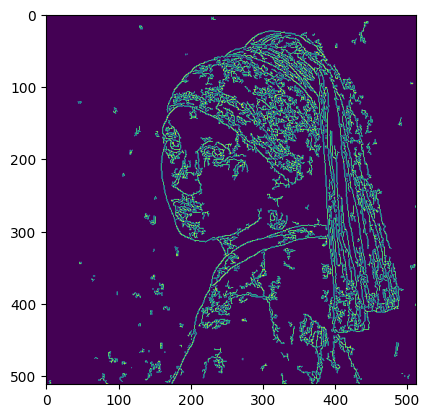

In [42]:
plt.imshow(edges);

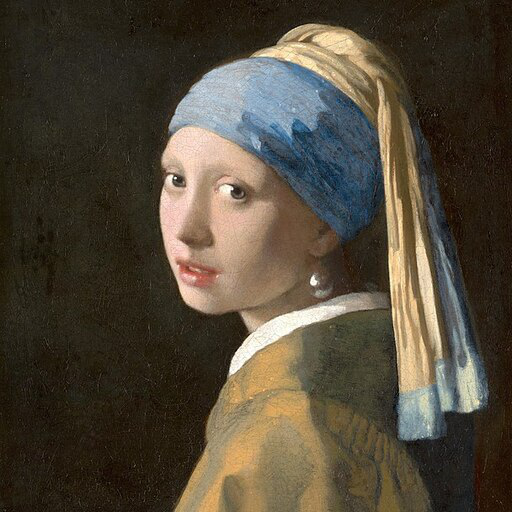

In [43]:
hint_image

In [44]:
num_samples=2
# from cnxs:control_utils.get_sdxl_sample
# i assume its used to
# - make 1 channel imags into 3 channel &
# - duplicate image for using classifier-free guidance
# control = torch.stack([tt.ToTensor()(hint[..., None].repeat(3, 2))] * num_samples).float().to('cuda')

from einops import repeat
edges = repeat(tensor(edges), 'h w -> b c h w', b=num_samples, c=3)

In [45]:
image.shape, edges.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 3, 512, 512]))

**Now we have everything!**

In [46]:
x = latent_model_input
t = t
c = {}
hint = edges.to(device, dtype=device_dtype)
no_control = False

In [47]:
hint.shape

torch.Size([2, 3, 512, 512])

___

In [48]:
x = torch.cat((x, c.get("concat", tensor([]).type_as(x))), dim=1)
if x.size(0) // 2 == hint.size(0): hint = torch.cat([hint, hint], dim=0) # for classifier free guidance

In [49]:
x.size(0), hint.size(0)

(2, 2)

In [50]:
x.shape, hint.shape

(torch.Size([2, 4, 64, 64]), torch.Size([2, 3, 512, 512]))

In [51]:
timesteps=t
context=c.get("crossattn", None)
y=c.get("vector", None)

In [52]:
timesteps

tensor(981)

**time information**

In [53]:
# # From UNet2DConditionModel.forward
# 1. time
timesteps = timesteps[None].to(device)

In [54]:
timesteps

tensor([981])

This is the time embedding

In [55]:
t_emb = get_timestep_embedding(
    timesteps, 
    two_stream_model.model_channels,
    flip_sin_to_cos=two_stream_model.flip_sin_to_cos,
    downscale_freq_shift=two_stream_model.freq_shift,
)

In [56]:
t_emb.shape, two_stream_model.model_channels

(torch.Size([1, 320]), 320)

And this is the time projection

In [57]:
temb = two_stream_model.base_model.time_embedding(t_emb)

In [58]:
temb.shape

torch.Size([1, 1280])

**text information**

In [59]:
two_stream_model.encoder_hid_proj

Linear(in_features=768, out_features=1280, bias=True)

In [60]:
cemb = two_stream_model.encoder_hid_proj(prompt_embeds)

In [61]:
temb.shape, cemb.shape

(torch.Size([1, 1280]), torch.Size([2, 77, 1280]))

In [62]:
emb = temb + cemb

___

**Q:** Okay, `two_stream_model.input_hint_block` can't handle 3 passed args (`hint`, `emb`, `context`), because I changed it from CN-XS's `TimestepEmbedSequential` to a regular `nn.Sequential`. What do I need to adjust so it works?

**A:** Here's the forward of `TimestepEmbedSequential`. As neither `Conv2d` nor `SiLU` are of type `TimestepBlock` or `SpatialTransformer`, only `x` gets passed into them, ie `emb` and `context` is ignored.
    
    def forward(
        self,
        x,
        emb,
        context=None,
        skip_time_mix=False,
        time_context=None,
        num_video_frames=None,
        time_context_cat=None,
        use_crossframe_attention_in_spatial_layers=False,
    ):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, context)
            elif layer.__class__.__name__ == 'SpatialTransformer':
                x = layer(x, context)
            else:
                x = layer(x)
        return x

So, I can just do `guided_hint = two_stream_model.input_hint_block(hint)`

In [63]:
guided_hint = two_stream_model.input_hint_block(hint)

In [64]:
hint.shape, guided_hint.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 320, 64, 64]))

In [68]:
h_ctrl = h_base = x
hs_base, hs_ctrl = [], []
it_enc_convs_in, it_enc_convs_out, it_dec_convs_in, it_dec_convs_out = map(
    iter,
    (two_stream_model.enc_zero_convs_in, two_stream_model.enc_zero_convs_out, two_stream_model.dec_zero_convs_in, two_stream_model.dec_zero_convs_out)
)
scales = iter(two_stream_model.scale_list)

In [69]:
h_base.shape, emb.shape, context

(torch.Size([2, 4, 64, 64]), torch.Size([2, 77, 1280]), None)

In [70]:
# Cross Control
# 0 - conv in
h_base = two_stream_model.base_model.conv_in(h_base)
h_ctrl = two_stream_model.control_model.conv_in(h_ctrl)

In [71]:
h_base.shape, h_ctrl.shape

(torch.Size([2, 320, 64, 64]), torch.Size([2, 320, 64, 64]))

In [72]:
module_base = next(iter(two_stream_model.base_model.down_blocks))

In [73]:
# from diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D.forward
hidden_states = h_base
temb = temb  # only time information
encoder_hidden_states = emb  # time and text-conditioning information
cross_attention_kwargs = context

attention_mask = None
encoder_attention_mask = None
additional_residuals=None

output_states = ()
lora_scale = 1.0

hidden_states.shape, temb.shape, lora_scale

(torch.Size([2, 320, 64, 64]), torch.Size([1, 1280]), 1.0)

**As we are (edit: were) getting errors, let's run a `forward` of one block manually**

In [74]:
blocks = list(zip(module_base.resnets, module_base.attentions))

In [75]:
i, (resnet, attn) = next(iter(enumerate(blocks)))
i

0

Apply resnets

In [76]:
hidden_states = resnet(hidden_states, temb, scale=lora_scale)
hidden_states.shape

torch.Size([2, 320, 64, 64])

Apply attentions

In [77]:
hidden_states = attn(
    hidden_states,
    encoder_hidden_states=encoder_hidden_states,
    cross_attention_kwargs=cross_attention_kwargs,
    attention_mask=attention_mask,
    encoder_attention_mask=encoder_attention_mask,
    return_dict=False,
)[0]
hidden_states.shape

torch.Size([2, 320, 64, 64])

**Q:** restnet expects `temb` as 2nd argument, while attention expects `emb` (`=temb+cemb`). So do we need to pass them both into the `CrossAttnDownBlock2D`? Afaik, there's no way to decompose them.

**A: Yes**, `CrossAttnDownBlock2D.forward` can handle receive them separately: 

In [78]:
CrossAttnDownBlock2D.forward?

Signature:
CrossAttnDownBlock2D.forward(
    self,
    hidden_states: torch.FloatTensor,
    temb: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.FloatTensor] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    additional_residuals=None,
)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
File:      ~/Documents/GitHub/diffusers/diffusers/src/diffusers/models/unet_2d_blocks.py
Type:      function

Okay, let's continue to manually run `module_base.forward`:

In [79]:
# apply additional residuals to the output of the last pair of resnet and attention blocks
if i == len(blocks) - 1 and additional_residuals is not None:
    hidden_states = hidden_states + additional_residuals

output_states = output_states + (hidden_states,)

Apply DownSample

In [80]:
module_base.downsamplers

ModuleList(
  (0): Downsample2D(
    (conv): LoRACompatibleConv(320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)

In [81]:
if module_base.downsamplers is not None:
    for downsampler in module_base.downsamplers:
        hidden_states = downsampler(hidden_states, scale=lora_scale)
    output_states = output_states + (hidden_states,) # save the output for use in skip connections

In [82]:
module_result = hidden_states, output_states

In [83]:
print(hidden_states.shape)
for i,o in enumerate(output_states): print(f'{i+1}: {o.shape}') 

torch.Size([2, 320, 32, 32])
1: torch.Size([2, 320, 64, 64])
2: torch.Size([2, 320, 32, 32])


**Wooooo!! We got a full pass of the DownBlock** 🚀🍾

Now we can run the loop

In [106]:
guided_hint = two_stream_model.input_hint_block(hint)

In [107]:
h_ctrl = h_base = x
hs_base, hs_ctrl = [], []
it_enc_convs_in, it_enc_convs_out, it_dec_convs_in, it_dec_convs_out = map(
    iter,
    (two_stream_model.enc_zero_convs_in, two_stream_model.enc_zero_convs_out, two_stream_model.dec_zero_convs_in, two_stream_model.dec_zero_convs_out)
)
scales = iter(two_stream_model.scale_list)

In [108]:
# Cross Control
# 0 - conv in
h_base = two_stream_model.base_model.conv_in(h_base)
h_ctrl = two_stream_model.control_model.conv_in(h_ctrl)

In [109]:
# from diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D.forward
hidden_states = h_base
temb = temb  # only time information
encoder_hidden_states = emb  # time and text-conditioning information
cross_attention_kwargs = context

attention_mask = None
encoder_attention_mask = None
additional_residuals=None

output_states = ()
lora_scale = 1.0

hidden_states.shape, temb.shape, lora_scale

(torch.Size([2, 320, 64, 64]), torch.Size([1, 1280]), 1.0)

I'm getting an error `RuntimeError: The size of tensor a (32) must match the size of tensor b (64) at non-singleton dimension 3` at

          5 h_ctrl = module_ctrl(h_ctrl, temb, cemb, context)[0]
          6 if guided_hint is not None:
    ----> 7     h_ctrl = h_ctrl + guided_hint
          8     guided_hint = None
          9 hs_base.append(h_base)

In [110]:
h_ctrl.shape, guided_hint.shape, h_base.shape

(torch.Size([2, 320, 64, 64]),
 torch.Size([2, 320, 64, 64]),
 torch.Size([2, 320, 64, 64]))

The shapes of `h_ctrl` (and `h_base`) are halfed.

**Q:** I assume this is because `module_base` / `module_ctrl` contain a downsampler?

In [111]:
my_module_ctrl, my_module_base = next(iter(zip(two_stream_model.base_model.down_blocks, two_stream_model.control_model.down_blocks)))

In [112]:
my_module_ctrl.downsamplers

ModuleList(
  (0): Downsample2D(
    (conv): LoRACompatibleConv(320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)

In [113]:
my_module_base.downsamplers

ModuleList(
  (0): Downsample2D(
    (conv): LoRACompatibleConv(320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)

**A:** Yes, both `module_base` and `module_ctrl` downsample by a factor of 2.

**Q:** When this is expected, why is there a shape conflict with `guided_hint`?

If I understand correctly from the CN-XS project page (https://vislearn.github.io/ControlNet-XS/), the hint is added to the input and then the sum is passed into the control model.

That's why `guided_hint` is set to `None` after one-time use. **But:** Shouldn't this be done *before* the first `module_ctrl`?

**Hypothesis:** The implementation in CN-XS is slightly wrong, but they didn't notice, because the models they use (SD2.1 and SDXL) use latents of size `4x32x32`

**No, SD2.1 and SLXL also use latents of size `4x64x64`** Hmmm

**A:** We can remove the shape conflict by moving the addition of the hint before the first block. Actually, this is what I think is the correct implememtation. But I don't understand how the paper team could miss this, as this produces an error? Well, let's park that and continue.

Edit: This is not an error; the paper team's implementation is correct! They consider the `conv_in` as part of the encoder, while I don't. Therefore their first encoder forward step is the conv_in forward, and only after that should the hint be added.

In [114]:
# 1 - input blocks (encoder)
if guided_hint is not None:
    h_ctrl = h_ctrl + guided_hint
    guided_hint = None

I'm getting an error in the 2nd iteration step.

    File ~/.local/share/virtualenvs/notebooks-cFP-wGb-/lib/python3.11/site-packages/torch/nn/functional.py:2530, in group_norm(input, num_groups, weight, bias, eps)
       2528     raise RuntimeError(f"Expected at least 2 dimensions for input tensor but received {input.dim()}")
       2529 _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))
    -> 2530 return torch.group_norm(input, num_groups, weight, bias, eps, torch.backends.cudnn.enabled)
    
    RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [320] and input of shape [2, 640, 32, 32]

The issue is that the weight channels should be `640` but arei `320`. This is due to the channel sizes (`ch_inout_ctrl`) being wrongly gathered, which itself is because I'm using a default `UNet2DConditionModel()` (which I'm using to keep things simple).

To make things work, I need to now use a correctly-shaped `UNet2DConditionModel`. Bye bye, simplicity.

---

**Alternative** Can I, for now, create a random `UNet2DConditionModel`, but with correct shapes?

The shape of the unet would have to be adjusted. Is that possible? My suspicion it it's not possible via passing arguments, but maybe via model surgery.

These are the params of `UNet2DConditionModel.__init__` that define the shape:

    sample_size: Optional[int] = None,
    in_channels: int = 4,
    out_channels: int = 4,
    
    down_block_types: Tuple[str] = ('CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D'),
    mid_block_type: Optional[str] = 'UNetMidBlock2DCrossAttn',
    up_block_types: Tuple[str] = ('UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D'),
    
    block_out_channels: Tuple[int] = (320, 640, 1280, 1280),
    layers_per_block: Union[int, Tuple[int]] = 2,
    
    transformer_layers_per_block: Union[int, Tuple[int]] = 1,
    
    encoder_hid_dim: Optional[int] = None,
    
    attention_head_dim: Union[int, Tuple[int]] = 8,
    num_attention_heads: Union[int, Tuple[int], NoneType] = None,
    
    time_embedding_dim: Optional[int] = None,
    time_cond_proj_dim: Optional[int] = None,
    conv_in_kernel: int = 3,
    conv_out_kernel: int = 3,

As expected, there's no way to change only the channels for each blocks first input; only for the blocks in their respective entirety (which I'd do via `block_out_channels`)

So **let's try model surgery**

In [131]:
my_unet = UNet2DConditionModel()

In [137]:
m0 = my_unet.down_blocks[0]

Recall a block is: Res -> Attn -> Res -> Attn -> Down.<br/>
So we need to change the input to the first Res.

In [136]:
m0.resnets[0]

ResnetBlock2D(
  (norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
  (conv1): LoRACompatibleConv(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb_proj): LoRACompatibleLinear(in_features=1280, out_features=320, bias=True)
  (norm2): GroupNorm(32, 320, eps=1e-05, affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (conv2): LoRACompatibleConv(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nonlinearity): SiLU()
)

Actually, it seems we need to change `norm1` (which doesn't change shapes) and `conv1` (which then tranforms the `640` back to `320`, so the net can continue as before)

In [140]:
m0.resnets[0].norm1

(GroupNorm(32, 320, eps=1e-05, affine=True),
 torch.nn.modules.normalization.GroupNorm)

In [139]:
type(m0.resnets[0].norm1)

torch.nn.modules.normalization.GroupNorm

In [141]:
m0.resnets[0].conv1

LoRACompatibleConv(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [142]:
type(m0.resnets[0].conv1)

diffusers.models.lora.LoRACompatibleConv

In [143]:
from torch.nn.modules.normalization import GroupNorm
from diffusers.models.lora import LoRACompatibleConv

In [144]:
GroupNorm.__init__??

Signature:
GroupNorm.__init__(
    self,
    num_groups: int,
    num_channels: int,
    eps: float = 1e-05,
    affine: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
Source:   
    def __init__(self, num_groups: int, num_channels: int, eps: float = 1e-5, affine: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if num_channels % num_groups != 0:
            raise ValueError('num_channels must be divisible by num_groups')

        self.num_groups = num_groups
        self.num_channels = num_channels
        self.eps = eps
        self.affine = affine
        if self.affine:
            self.weight = Parameter(torch.empty(num_channels, **factory_kwargs))
            self.bias = Parameter(torch.empty(num_channels, **factory_kwargs))
        else:
            self.register_parameter('

In [145]:
old_norm1 = m0.resnets[0].norm1
old_conv1 = m0.resnets[0].conv1

In [167]:
norm_args = 'num_groups num_channels eps affine'.split(' ')

for a in norm_args:
    if not hasattr(old_norm1, a): print(f'Our norm doesnt have "{a}", damn')

norm_kwargs = { a: getattr(old_norm1, a) for a in norm_args }

norm_kwargs['num_channels'] = 2*norm_kwargs['num_channels']  # surgery done here (640 channels instead of 320)

norm_kwargs

{'num_groups': 32, 'num_channels': 640, 'eps': 1e-05, 'affine': True}

In [168]:
new_norm1 = GroupNorm(**norm_kwargs)

In [148]:
LoRACompatibleConv.__init__??

Signature:
LoRACompatibleConv.__init__(
    self,
    *args,
    lora_layer: Optional[diffusers.models.lora.LoRAConv2dLayer] = None,
    **kwargs,
)
Docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
Source:   
    def __init__(self, *args, lora_layer: Optional[LoRAConv2dLayer] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.lora_layer = lora_layer
File:      ~/Documents/GitHub/diffusers/diffusers/src/diffusers/models/lora.py
Type:      function

In [149]:
LoRACompatibleConv.mro()

[diffusers.models.lora.LoRACompatibleConv,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.conv._ConvNd,
 torch.nn.modules.module.Module,
 object]

In [169]:
lora_conv_args = 'in_channels out_channels kernel_size stride padding dilation groups bias padding_mode lora_layer'.split(' ')

for a in lora_conv_args:
    if not hasattr(old_conv1, a): print(f'Our conv doesnt have "{a}", damn')

lora_conv_kwargs = {
    a: getattr(old_conv1, a) for a in lora_conv_args
}
lora_conv_kwargs['bias'] = 'bias' in lora_conv_kwargs  # as param, bias is a boolean. as attr, its a tensor.
lora_conv_kwargs['in_channels'] = 2*lora_conv_kwargs['in_channels']  # surgery done here (640 channels instead of 320)

lora_conv_kwargs

{'in_channels': 640,
 'out_channels': 320,
 'kernel_size': (3, 3),
 'stride': (1, 1),
 'padding': (1, 1),
 'dilation': (1, 1),
 'groups': 1,
 'bias': True,
 'padding_mode': 'zeros',
 'lora_layer': None}

In [170]:
new_conv1 = LoRACompatibleConv(**lora_conv_kwargs)

In [189]:
m0.resnets[0].norm1 = new_norm1

In [190]:
m0.resnets[0].conv1 = new_conv1

Model surgery works in principle!

Now, we need to actually adjust the **2nd** block's input, not the 1st block's. Remember, we need to do the adjustment, because in CN-XS, information also flows from the base model back to the control model. And information is first available after the 1st block, ie at the beginning of the 2nd block.

In [192]:
def double_block_input(unet, block_no):
    assert block_no!=0, "Only after block 0 do we have info to pass from base to control, so you probably didn't mean block_no=0." 
    old_norm1, old_conv1 = unet.down_blocks[block_no].resnets[0].norm1,unet.down_blocks[block_no].resnets[0].conv1
    # norm
    norm_args = 'num_groups num_channels eps affine'.split(' ')
    for a in norm_args: assert hasattr(old_norm1, a)
    norm_kwargs = { a: getattr(old_norm1, a) for a in norm_args }
    norm_kwargs['num_channels'] = 2*norm_kwargs['num_channels']  # surgery done here
    # conv
    lora_conv_args = 'in_channels out_channels kernel_size stride padding dilation groups bias padding_mode lora_layer'.split(' ')
    for a in lora_conv_args: assert hasattr(old_conv1, a)
    lora_conv_kwargs = { a: getattr(old_conv1, a) for a in lora_conv_args }
    lora_conv_kwargs['bias'] = 'bias' in lora_conv_kwargs  # as param, bias is a boolean, but as attr, it's a tensor.
    lora_conv_kwargs['in_channels'] = 2*lora_conv_kwargs['in_channels']  # surgery done here
    # swap old with new modules
    unet.down_blocks[block_no].resnets[0].norm1 = GroupNorm(**norm_kwargs)
    unet.down_blocks[block_no].resnets[0].conv1 = LoRACompatibleConv(**lora_conv_kwargs)

In [204]:
double_block_input(two_stream_model.control_model, block_no=1)

In [205]:
two_stream_model.control_model.down_blocks[1].resnets[0].norm1

GroupNorm(32, 1280, eps=1e-05, affine=True)

In [206]:
double_block_input(two_stream_model.control_model, block_no=2)

In [207]:
two_stream_model.control_model.down_blocks[2].resnets[0].norm1

GroupNorm(32, 1280, eps=1e-05, affine=True)

In [208]:
two_stream_model.control_model.down_blocks[2].resnets[0].conv1

LoRACompatibleConv(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

**Model surgery works! Whoop whoop** 

---

Let's continue in another notebook :)